# Let's understand possible ways in which the card game Yu-Gi-Oh! may have changed through analysis of the cards

On a personal note, I used to love playing the game as a teenager and I have recently tried to it play again. It had changed so much, I'm still not sure I completely understand the way it was played. 
<div>
    <img src="https://preview.redd.it/me-whos-trying-to-get-back-to-the-game-v0-02xzy4rnqycb1.jpg?width=640&crop=smart&auto=webp&s=c93b16f6372b8bb023d8c866757cb91192983629" width="400"/>
</div>

I saw this meme and found it accurate. While learning about data analysis and data visualisation, I thought it would be an interresting subject for a project.

*Limitations:*  
There are different game formats which have gone through multiple rule changes but in this exploratory data analysis is solely focused on the cards themselves.

*Goals:*
1. **Study the two main game formats (TCG and OCG) cards, their releases over time and their forbidden cards.**
2. **Dig deeper into the Monster Cards parameters and how they could have changed.**
3. **Comparing the pool of cards available in 2005 and 2024 for the TCG format (as a reference to the meme).**
4. **Analysing the descriptions of the cards looking for complexification and the enabling of "chains".**
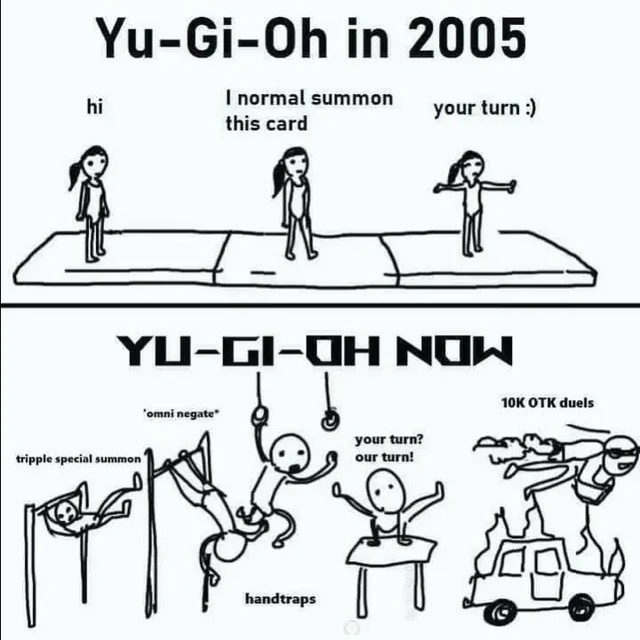
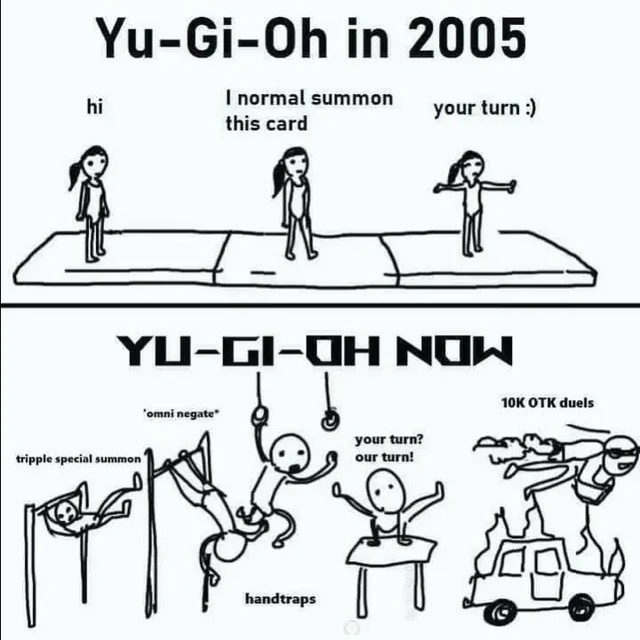

In [1]:
#setup
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import fuzzywuzzy
from fuzzywuzzy import process
import charset_normalizer
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

print("Setup Complete. IT'S TIME TO D-D-D-DUEL.")

Setup Complete. IT'S TIME TO D-D-D-DUEL.


/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
#Loading the data
cards_filepath = "/kaggle/input/yugioh-cards/cards.csv"
cards_data = pd.read_csv(cards_filepath)

pd.set_option('display.max_colwidth', None)

# Replace inf and -inf with NaN explicitly
cards_data = cards_data.replace([np.inf, -np.inf], np.nan)

In [3]:
#Looking for empty cells in each column
missing_values_count = cards_data.isnull().sum()
missing_values_count[:]

id                     0
name                   0
type                   0
desc                   0
atk                 4650
def                 5065
level               5065
race                   1
attribute           4650
scale              12933
archetype           5493
linkval            12866
linkmarkers        12866
image_url              0
image_url_small        0
ban_tcg            13086
ban_ocg            13091
ban_goat           13208
staple             13217
views                  0
viewsweek              0
upvotes                0
downvotes              0
formats               13
treated_as         13139
tcg_date             416
ocg_date             400
konami_id            480
has_effect             0
dtype: int64

There are a lot of missing values regarding the characteristics of cards like atk, def but this is explained contextually because they only apply to the monster cards types.

In [4]:
#Looking for duplicates in cards names
total_values_cards = cards_data['name'].value_counts().sum()
total_unique_values_cards = cards_data['name'].nunique()

print("The number of entries in the name column is :",total_values_cards, ", and the number of unique entries in the name column is :",total_unique_values_cards)

The number of entries in the name column is : 13281 , and the number of unique entries in the name column is : 13281


There are no duplicates in the names of the cards so we can continue on with our analysis.

### Repartition of the type of cards in the data set :

Text(0, 0.5, 'Type')

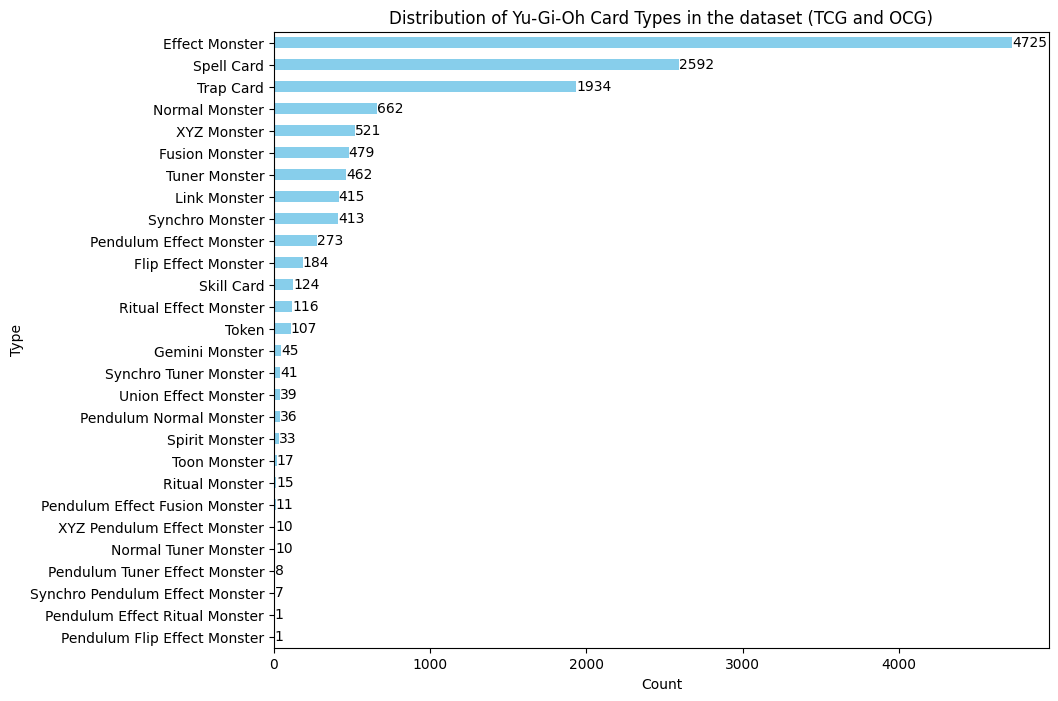

In [5]:
# Get the value counts for the 'type' column
type_counts = cards_data['type'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 8))
type_counts.sort_values().plot(kind='barh', color='skyblue')
# Add counts to the bars
for index, value in enumerate(type_counts.sort_values()):
    plt.text(value, index, str(value), va='center')  # `value` is the count, `index` is the bar position
plt.title('Distribution of Yu-Gi-Oh Card Types in the dataset (TCG and OCG)')
plt.xlabel('Count')
plt.ylabel('Type')

## TCG (Trading Card Game) and OCG (Original Card Game)

**The Yu-Gi-Oh game and cards are separated into 2 formats depending on your location : TCG (Trading Card Game) and OCG (Original Card Game).**
> OCG is played in asia (Japan, Korea, China and so on) while the TCG is played everywhere else (America, Europe and so on). (source: https://yugipedia.com/wiki/Forum:What_is_OCG_and_TCG%3F_whats_the_difference%3F)

In competitive spheres the rules and availability of the cards are different depending on TCG and OCG. This include cards that have become banned or limited. 

In [6]:
print("The data type of the dates in tcg_date is",cards_data['tcg_date'].dtype)

The data type of the dates in tcg_date is object


In [7]:
#Convert to the date format because the type of the column 'tcg_date' is object
cards_data['tcg_date_parsed']= pd.to_datetime(cards_data['tcg_date'], format= "%Y-%m-%d", errors="coerce")
#Convert to the date format because the type of the column 'ocg_date' is object
cards_data['ocg_date_parsed']= pd.to_datetime(cards_data['ocg_date'], format= "%Y-%m-%d",errors="coerce")

#Time categories
#year
cards_data["tcg_year"] = cards_data["tcg_date_parsed"].dt.year
cards_data["ocg_year"] = cards_data["ocg_date_parsed"].dt.year

cards_data = cards_data.dropna(subset=["tcg_year", "ocg_year"])
cards_data["tcg_year"] = cards_data["tcg_year"].astype(int)
cards_data["ocg_year"] = cards_data["ocg_year"].astype(int)

#year months for later use
cards_data["tcg_year_month"] = cards_data["tcg_date_parsed"].dt.to_period("M")
cards_data["ocg_year_month"] = cards_data["ocg_date_parsed"].dt.to_period("M")

cards_data["tcg_year_month"] = cards_data["tcg_year_month"].dt.to_timestamp()
cards_data["ocg_year_month"] = cards_data["ocg_year_month"].dt.to_timestamp()

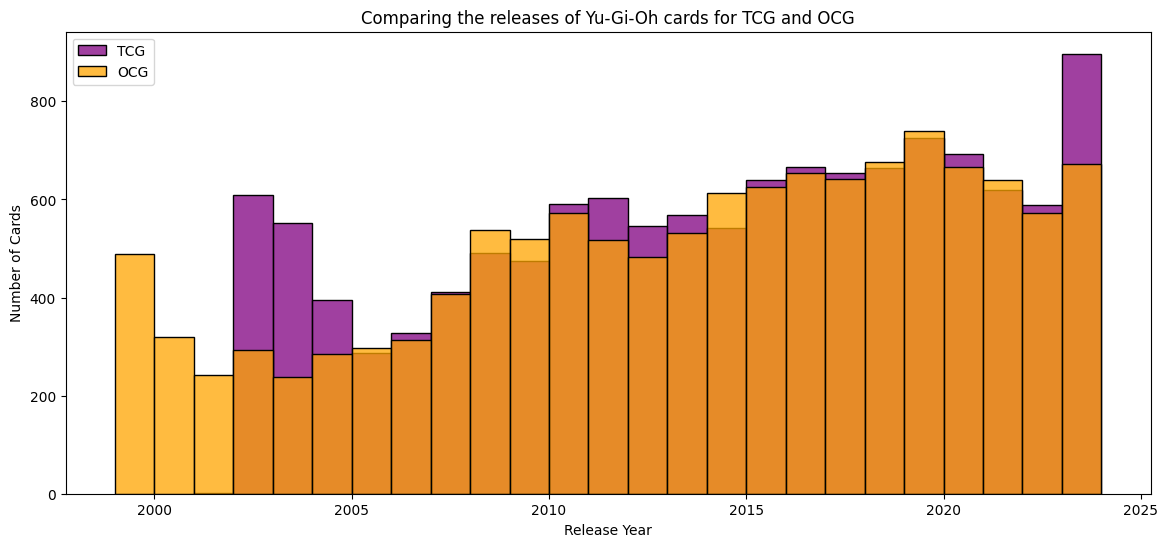

In [8]:
#Let's analyse the Cards releases

plt.figure(figsize=(14,6))
plt.title("Comparing the releases of Yu-Gi-Oh cards for TCG and OCG")
sns.histplot(cards_data["tcg_year"], color="purple", label="TCG", bins=range(cards_data["tcg_year"].min(), cards_data["tcg_year"].max() + 1) )
sns.histplot(cards_data["ocg_year"], color= "orange", label= "OCG", bins=range(cards_data["ocg_year"].min(), cards_data["ocg_year"].max() + 1))
plt.xlabel("Release Year")
plt.ylabel("Number of Cards")
plt.legend()
sns.set_style("whitegrid")
plt.show()

In [9]:
#first releases
print("The earliest year a card was released on for the Original Card Game (OCG) was", int(cards_data["ocg_year"].min()),
      ", \n and the earliest year for the more international Trading Card Game (TCG) was",int(cards_data["tcg_year"].min()) ,"." )

The earliest year a card was released on for the Original Card Game (OCG) was 1999 , 
 and the earliest year for the more international Trading Card Game (TCG) was 2001 .


In [10]:
#investigating 2001 for the TCG format
tcg_2001=0
tcg_2002=0

for i in cards_data["tcg_year"]:
    if i ==2001:
        tcg_2001 +=1

for i in cards_data["tcg_year"]:
    if i ==2002:
        tcg_2002 +=1
        
print("The number of cards released during the first year of TCG was :", tcg_2001, "; and the second year :", tcg_2002, ".")
print("The first card released in 2001 for TCG was :" , cards_data.loc[cards_data["tcg_year"] == 2001, "name"].iloc[0])

print(cards_data.loc[cards_data["tcg_year"] == 2001, "formats"])

The number of cards released during the first year of TCG was : 1 ; and the second year : 609 .
The first card released in 2001 for TCG was : Summoned Skull
11002    GOAT|OCG GOAT|Duel Links|Common Charity|Speed Duel|TCG|OCG|Master Duel
Name: formats, dtype: object


Why has only the card Summonned Skull been released in 2001 ?

After some research, I have found that it was first released as a sample promotional cards in 2001 for retailers in North America. https://yugipedia.com/wiki/Summoned_Skull https://yugipedia.com/wiki/Summoned_Skull_Sample_promotional_card

As we can see in the rest of the dataset, the launch of Yu-Gi-Oh for the TCG market really started in 2002.

I will consider that the promotional cards as regular cards since according to https://yugioh.fandom.com/wiki/Category:TCG_promotional_cards , there are only 84 items regarding the "promotional" term in search; and the sample cards are still published soon after.

In [11]:
#Fixing the Summoned Skull issue because the promotionnal release date is affecting the releases per year
#because it is impacting later calculations
cards_data.loc[cards_data["tcg_year"] == 2001, "tcg_year"] = 2002

### Are there more cards in TCG or OCG ?

In [12]:
#Total of cards
total_cards_tcg = cards_data['tcg_date_parsed'].value_counts().sum()
total_cards_ocg = cards_data['ocg_date_parsed'].value_counts().sum()

print("The total number of cards for TCG is",total_cards_tcg," and for OCG is",total_cards_ocg)

#Number of cards in the ban list
total_ban_tcg = cards_data['ban_tcg'].value_counts().sum()
total_ban_ocg = cards_data['ban_ocg'].value_counts().sum()

print('The ban list including "Banned","Limited" and "Semi-Limited" statuses for TCG is',total_ban_tcg,"and for OCG is ",total_ban_ocg)

#Number of cards completely banned
total_banned_tcg = cards_data[cards_data['ban_tcg'] == "Banned"].shape[0]
total_banned_ocg = cards_data[cards_data['ban_ocg'] == "Banned"].shape[0]

#Usable cards in TCG vs OCG
usable_cards_tcg = total_cards_tcg - total_ban_tcg
usable_cards_ocg = total_cards_ocg - total_ban_ocg

print("The number of usable cards to this day for TCG is",usable_cards_tcg,"and for OCG is",usable_cards_ocg)

percent_of_bans_tcg = round(total_ban_tcg/total_cards_tcg*100, 2)
percent_of_bans_ocg = round(total_ban_ocg/total_cards_ocg*100, 2)
percent_banned_tcg = round(total_banned_tcg/total_cards_tcg*100, 2)
percent_banned_ocg = round(total_banned_ocg/total_cards_ocg*100, 2)

print("The cards in the ban list represent", percent_of_bans_tcg ,"% of the TCG pool.")
print("The cards in the ban list represent", percent_of_bans_ocg,"% of the OCG pool.")

print("And the number of cards completely banned is even lower. \n It equals to", percent_banned_tcg ,"% of the TCG pool and ",percent_banned_ocg, "% for the OCG pool of cards." )

The total number of cards for TCG is 12542  and for OCG is 12542
The ban list including "Banned","Limited" and "Semi-Limited" statuses for TCG is 195 and for OCG is  190
The number of usable cards to this day for TCG is 12347 and for OCG is 12352
The cards in the ban list represent 1.55 % of the TCG pool.
The cards in the ban list represent 1.51 % of the OCG pool.
And the number of cards completely banned is even lower. 
 It equals to 0.84 % of the TCG pool and  0.69 % for the OCG pool of cards.


### Banned and limited cards
To continue looking for the differences between the TCG and OCG game formats, let's examine their ban lists to see if they coincide.

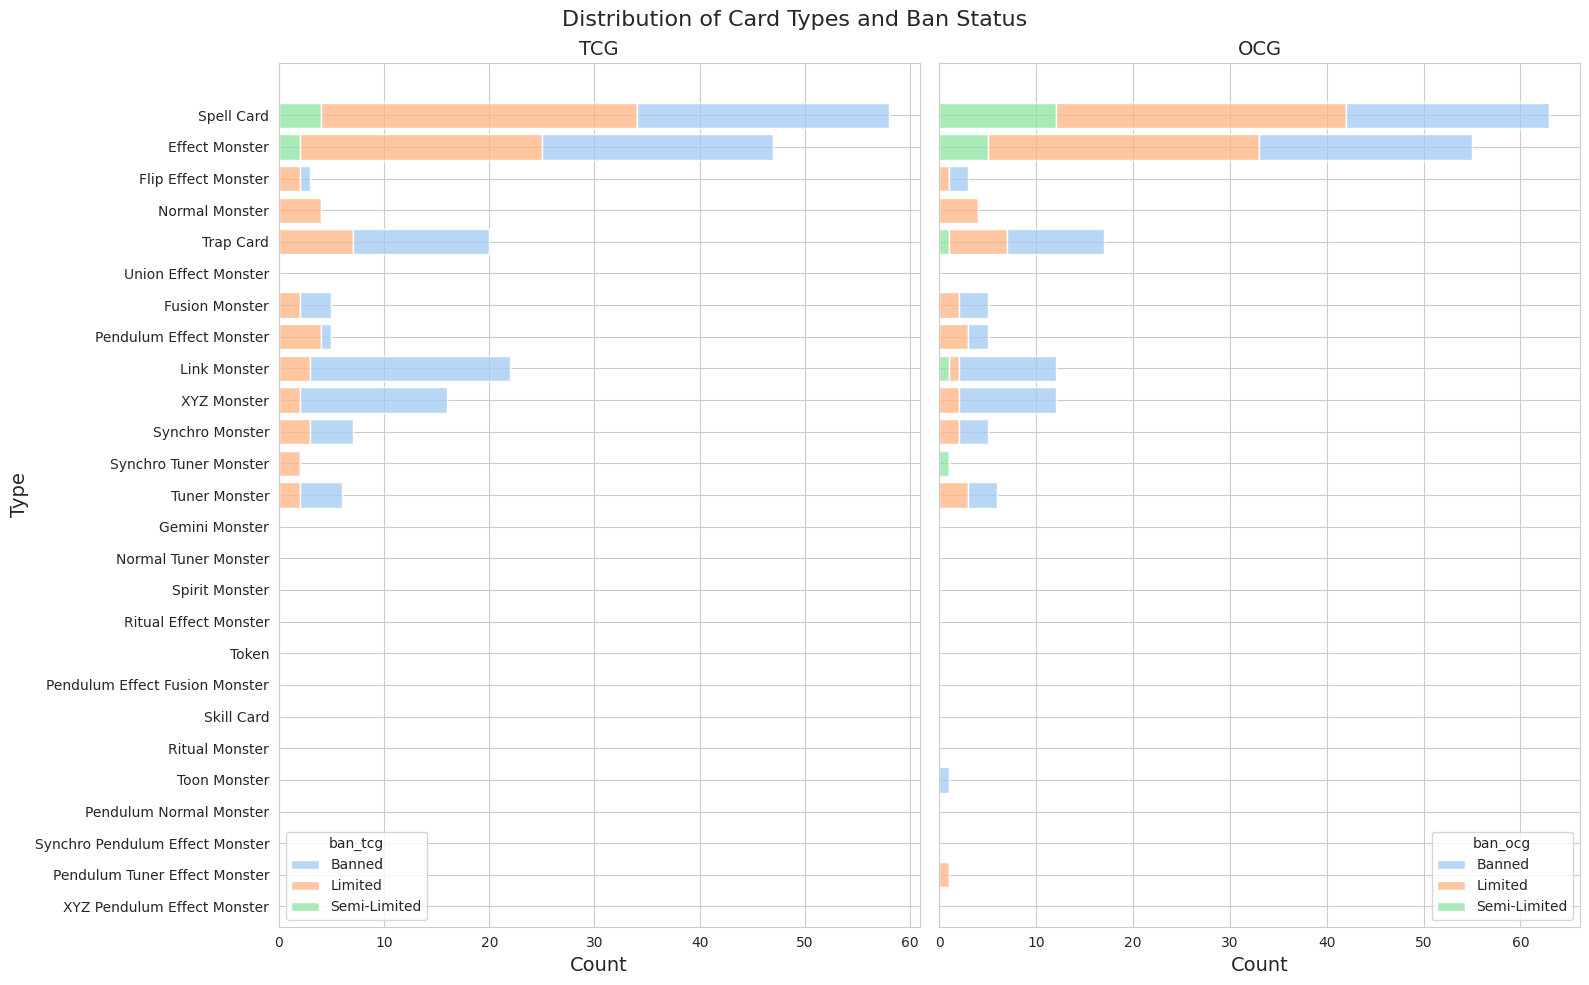

In [13]:
#Ban statuses
# Ensure 'ban_tcg' and 'ban_ocg' columns are categorical to avoid warnings
cards_data["ban_tcg"] = cards_data["ban_tcg"].astype("category")
cards_data["ban_ocg"] = cards_data["ban_ocg"].astype("category")


fig, axes = plt.subplots(1, 2, figsize=(16, 10), sharey=True)
fig.suptitle('Distribution of Card Types and Ban Status', ha = "center", fontsize=16)

ax = sns.histplot( data=cards_data, y='type', hue='ban_tcg', multiple='stack', shrink=0.8, palette='pastel',ax=axes[0] ) # Specify which subplot to draw on

#for container in ax.containers:
#    ax.bar_label(container, fmt='%d', fontsize=8)

ax.set_title("TCG", fontsize=14)
ax.set_xlabel("Count", fontsize=14)
ax.set_ylabel("Type", fontsize=14)

ax_a = sns.histplot( data=cards_data, y='type', hue='ban_ocg', multiple='stack', shrink=0.8, palette='pastel', ax=axes[1])  # Specify which subplot to draw on 

#for container in ax_a.containers:
#    ax_a.bar_label(container, fmt='%d', fontsize=8)

ax_a.set_title("OCG", fontsize=14)
ax_a.set_xlabel("Count", fontsize=14)
ax_a.set_ylabel("")  # Remove redundant y-axis label

plt.tight_layout()

plt.show()

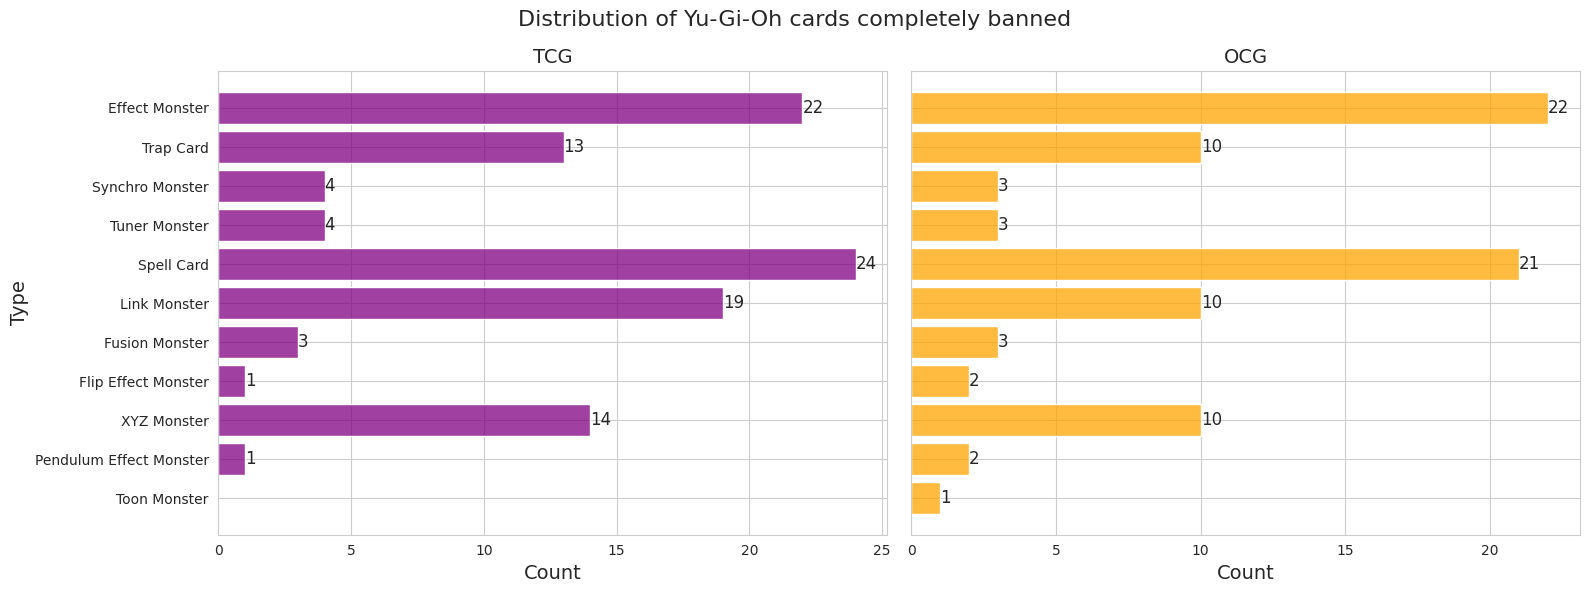

In [14]:
#cards that are 'Banned' and not limited plot

# Ensure 'ban_tcg' and 'ban_ocg' columns are categorical to avoid warnings
cards_data["ban_tcg"] = cards_data["ban_tcg"].astype("category")
cards_data["ban_ocg"] = cards_data["ban_ocg"].astype("category")

banned_tcg_data = cards_data[cards_data["ban_tcg"] == "Banned"]
banned_ocg_data = cards_data[cards_data["ban_ocg"] == "Banned"]


fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
fig.suptitle('Distribution of Yu-Gi-Oh cards completely banned', ha = "center", fontsize=16)

ax_1 = sns.histplot(data=banned_tcg_data, y='type', multiple='stack', shrink=0.8, color = 'purple',ax=axes[0], legend=False ) # Specify which subplot to draw on

for container in ax_1.containers:
    ax_1.bar_label(container, fmt='%d', fontsize=12)

ax_1.set_title("TCG", fontsize=14)
ax_1.set_xlabel("Count", fontsize=14)
ax_1.set_ylabel("Type", fontsize=14)

ax_2 = sns.histplot(data=banned_ocg_data, y='type', multiple='stack', shrink=0.8, color = 'orange' , ax=axes[1],legend=False)  # Specify which subplot to draw on 

for container in ax_2.containers:
    ax_2.bar_label(container, fmt='%d', fontsize=12)

ax_2.set_title("OCG", fontsize=14)
ax_2.set_xlabel("Count", fontsize=14)
ax_2.set_ylabel("") 

plt.tight_layout()

plt.show()

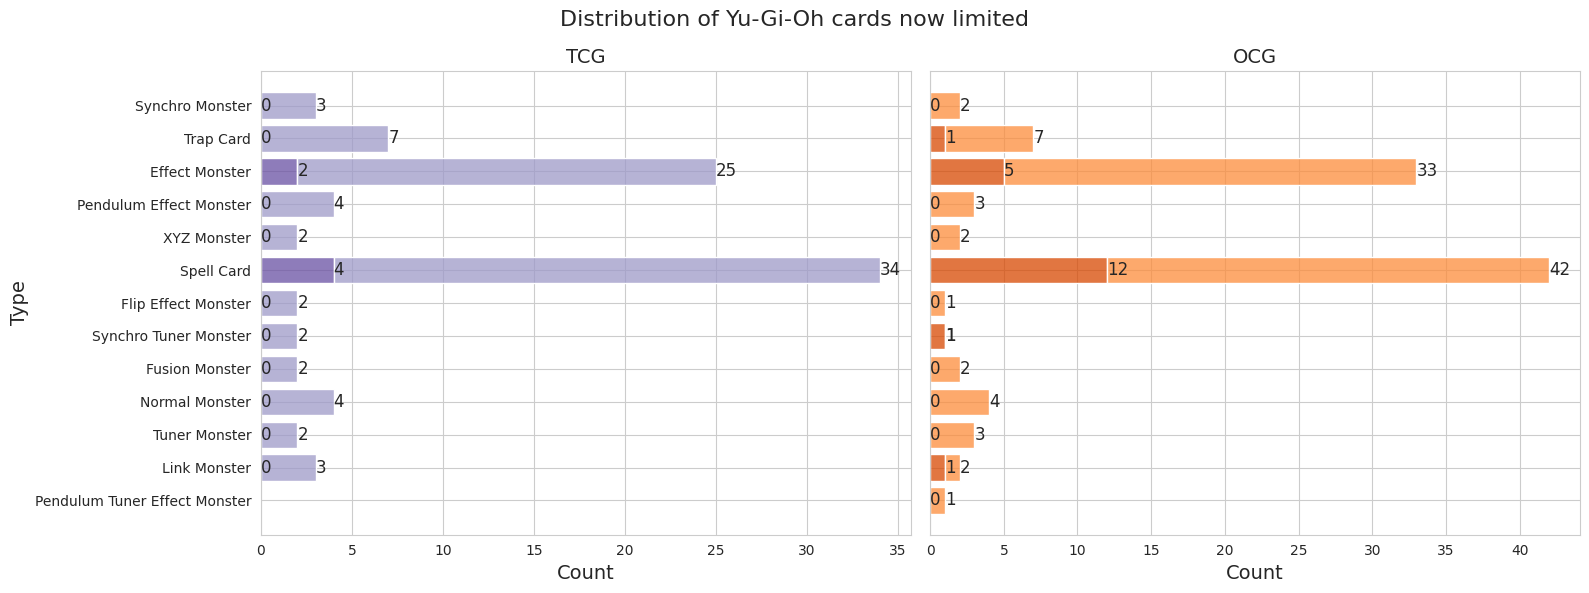

In [15]:
#limited and semi limited plot
limited_tcg_data = cards_data[cards_data["ban_tcg"].isin(["Limited", "Semi-Limited"])]
limited_ocg_data = cards_data[cards_data["ban_ocg"].isin(["Limited", "Semi-Limited"])]


fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
fig.suptitle('Distribution of Yu-Gi-Oh cards now limited', ha = "center", fontsize=16)

ax_1 = sns.histplot(data=limited_tcg_data, y='type', hue='ban_tcg', multiple='stack', shrink=0.8, palette = 'Purples',ax=axes[0], legend=False ) # Specify which subplot to draw on

for container in ax_1.containers:
    ax_1.bar_label(container, fmt='%d', fontsize=12)

ax_1.set_title("TCG", fontsize=14)
ax_1.set_xlabel("Count", fontsize=14)
ax_1.set_ylabel("Type", fontsize=14)

ax_2 = sns.histplot(data=limited_ocg_data, y='type', hue='ban_ocg', multiple='stack', shrink=0.8, palette = 'Oranges' , ax=axes[1],legend=False)  # Specify which subplot to draw on 

for container in ax_2.containers:
    ax_2.bar_label(container, fmt='%d', fontsize=12)

ax_2.set_title("OCG", fontsize=14)
ax_2.set_xlabel("Count", fontsize=14)
ax_2.set_ylabel("")  # Remove redundant y-axis label

plt.tight_layout()

plt.show()

There is no significant size difference in the TCG and OCG card pools, and the ban lists amount to 1.5% of both of them.
Though, we can see here some differences in the distribution of the ban lists, which means there is a slight difference in the cards authorised to play.

*For context: When players build their decks, if a card is limited they can include only one copy of it and two if the card is semi-limited.*

It would be interesting to look more closely at the significace and effects of the cards on the ban lists. 

## Trends in Monsters Cards releases

In [16]:
#creating a new type column where we regroup all types of monsters (tokens are left seperate even if they are considered as monsters too)
cards_data["primary_type"]= cards_data.loc[:,"type"]

#renaming all the monster adjacent cards to monster primary type
cards_data.loc[cards_data["primary_type"].str.contains(r'\bMonster\b', regex=True) ,'primary_type'] = 'Monster Card'

# ensure "primary_type" columns is categorical
cards_data["primary_type"] = cards_data["primary_type"].astype("category")

#to check
cards_data["primary_type"].value_counts()

#to use more easily and only select the monster type of cards
monster_cards_data = cards_data[cards_data["primary_type"]=="Monster Card"]


### Attack points  

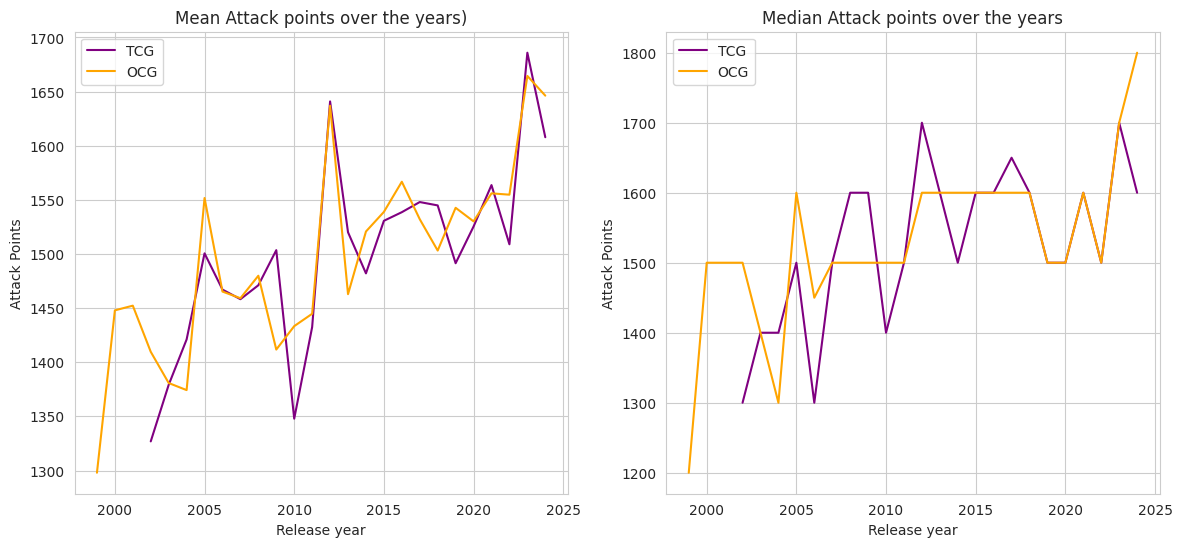

In [17]:
#atk plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))


sns.lineplot(data=monster_cards_data, x="tcg_year", y="atk", label="TCG", color='purple', ax=axes[0], errorbar=None)
sns.lineplot(data=monster_cards_data, x="ocg_year", y="atk", label="OCG", color='orange', ax=axes[0], errorbar=None)
axes[0].set_title("Mean Attack points over the years)")
axes[0].set_xlabel("Release year")
axes[0].set_ylabel("Attack Points")

sns.lineplot(data=monster_cards_data, x="tcg_year", y="atk", label="TCG", color='purple', ax=axes[1], estimator=np.median, errorbar=None)
sns.lineplot(data=monster_cards_data, x="ocg_year", y="atk", label="OCG", color='orange', ax=axes[1], estimator=np.median, errorbar=None)
axes[1].set_title("Median Attack points over the years")
axes[1].set_xlabel("Release year")
axes[1].set_ylabel("Attack Points")

plt.show()

###  Defense points

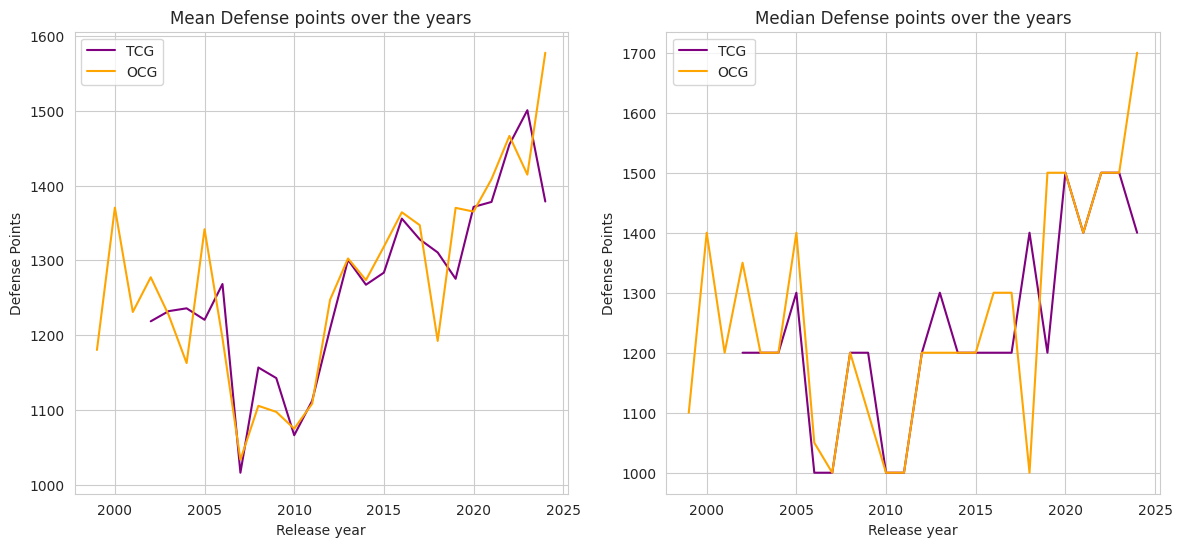

In [18]:
#def plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))


sns.lineplot(data=monster_cards_data, x="tcg_year", y="def", label="TCG", color='purple', ax=axes[0], errorbar=None)
sns.lineplot(data=monster_cards_data, x="ocg_year", y="def", label="OCG", color='orange', ax=axes[0], errorbar=None)
axes[0].set_title("Mean Defense points over the years")
axes[0].set_xlabel("Release year")
axes[0].set_ylabel("Defense Points")

sns.lineplot(data=monster_cards_data, x="tcg_year", y="def", label="TCG", color='purple', ax=axes[1], estimator=np.median, errorbar=None)
sns.lineplot(data=monster_cards_data, x="ocg_year", y="def", label="OCG", color='orange', ax=axes[1], estimator=np.median, errorbar=None)
axes[1].set_title("Median Defense points over the years")
axes[1].set_xlabel("Release year")
axes[1].set_ylabel("Defense Points")

plt.show()

Same as for the Attack points, there seems to have been an event between 2007 and 2011. 
This is something that could be investigated further on a later date.

### Levels

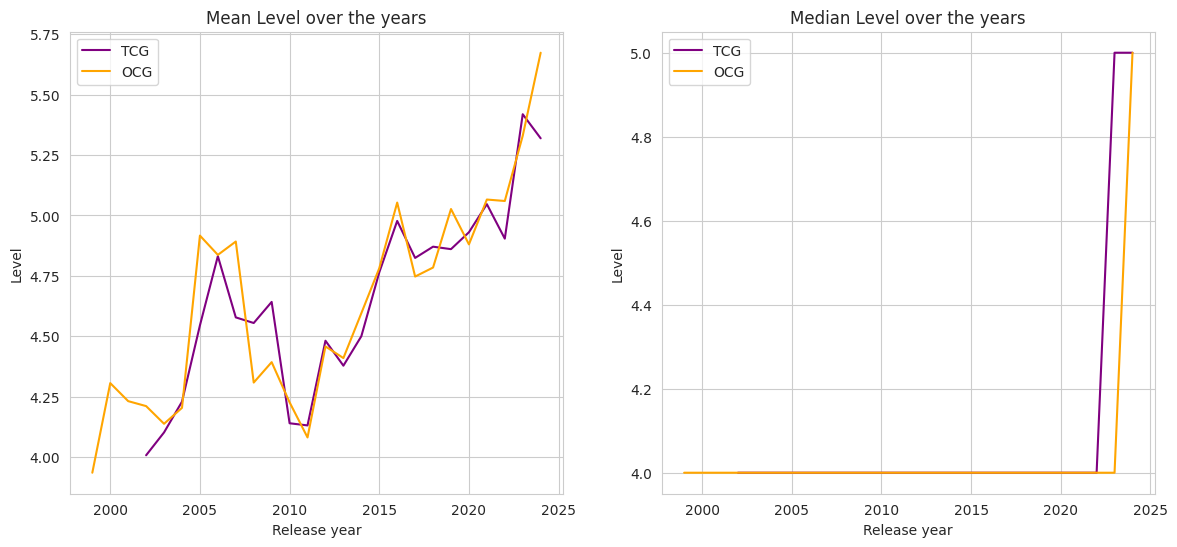

In [19]:
#level plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))


sns.lineplot(data=monster_cards_data, x="tcg_year", y="level", label="TCG", color='purple', ax=axes[0], errorbar=None)
sns.lineplot(data=monster_cards_data, x="ocg_year", y="level", label="OCG", color='orange', ax=axes[0], errorbar=None)
axes[0].set_title("Mean Level over the years")
axes[0].set_xlabel("Release year")
axes[0].set_ylabel("Level")

sns.lineplot(data=monster_cards_data, x="tcg_year", y="level", label="TCG", color='purple', ax=axes[1], estimator=np.median, errorbar=None)
sns.lineplot(data=monster_cards_data, x="ocg_year", y="level", label="OCG", color='orange', ax=axes[1], estimator=np.median, errorbar=None)
axes[1].set_title("Median Level over the years")
axes[1].set_xlabel("Release year")
axes[1].set_ylabel("Level")

plt.show()

The number of cards released with higher levels could partially explain the increased need to special summon Monsters for example with chains.  
*Note: Monster cards need from level 5 to 12 require "tributes" to be summoned or to be specially summoned.*

### Attributes

In [20]:
#making a function to use in 2 different graphs
def m_card_stacked_hist_over_time(time_col= None, parameter_col = None , formats=None, ax=None):
    data_attributes = (cards_data[cards_data["primary_type"] == "Monster Card"].groupby([time_col, parameter_col]).size().reset_index(name="count"))

    # If no ax is provided, create a new figure
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    sns.histplot(data=data_attributes, y=time_col, hue=parameter_col, weights="count", multiple="stack", palette='hsv', legend=True, bins=range(cards_data[time_col].min(), cards_data[time_col].max() + 1), ax=ax)
    
    # Add labels and title
    ax.set_title(f"Distribution of {parameter_col} over time {formats}", fontsize=14)
    ax.set_ylabel("Release Year", fontsize=12)
    ax.set_xlabel("Number of Monster cards", fontsize=12)
    ax.tick_params(axis="x", rotation=45) 
    
    if ax is None:
        plt.show()    

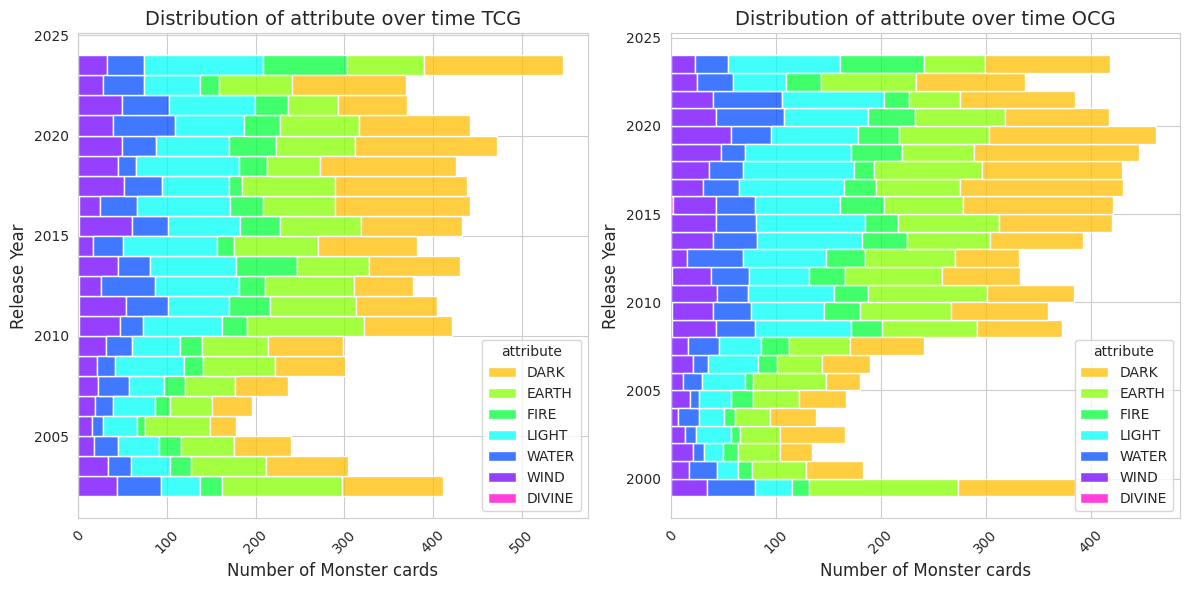

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

m_card_stacked_hist_over_time(time_col= "tcg_year", parameter_col = "attribute", formats= "TCG", ax=axes[0])
m_card_stacked_hist_over_time(time_col= "ocg_year", parameter_col = "attribute", formats= "OCG", ax=axes[1])

plt.tight_layout()
plt.show()

In [22]:
#Finding out when the divine cards where released and how many there are in the whole data set
#print(cards_data.loc[cards_data["attribute"] == "DIVINE", "name"])
print("\n They don't seem to show very well on the plot but there are",len(cards_data.loc[cards_data["attribute"] == "DIVINE"]), "cards with the DIVINE attribute, in the whole dataset.")


 They don't seem to show very well on the plot but there are 5 cards with the DIVINE attribute, in the whole dataset.


### Monster Type

This is sometime the word "race" used for it, as it is the name of the column. In English the word "Type" is used while "type" (all lowercase) is the type of the card (Monster, Trap, etc.).

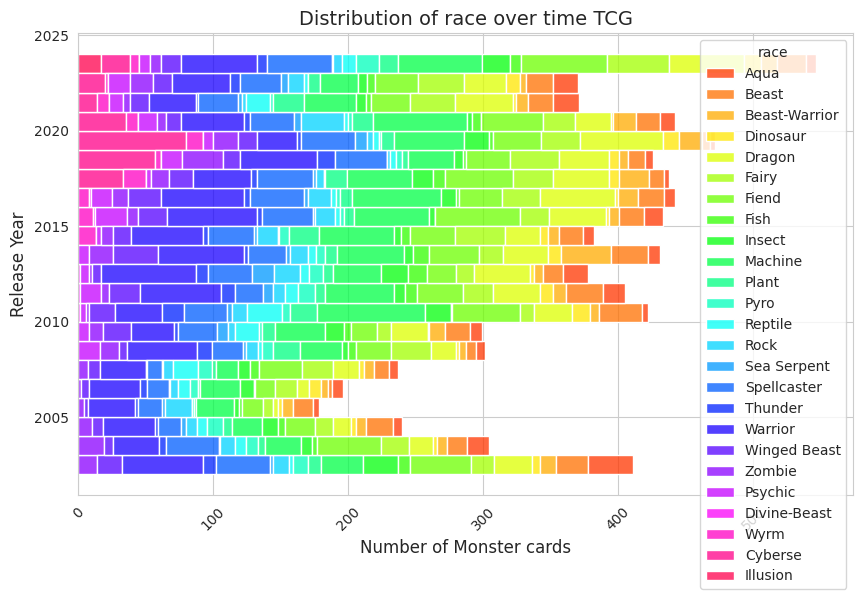

In [23]:
m_card_stacked_hist_over_time(time_col= "tcg_year", parameter_col = "race", formats= "TCG")

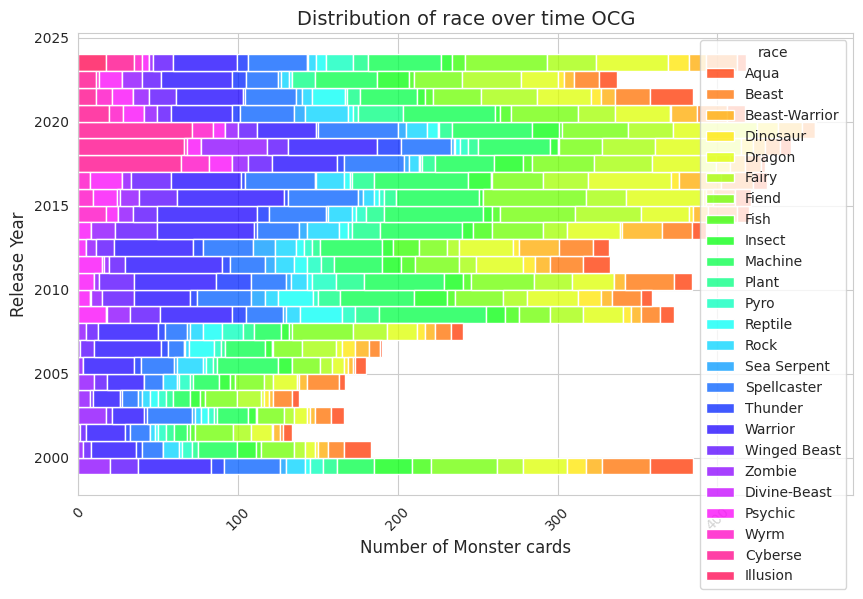

In [24]:
m_card_stacked_hist_over_time(time_col= "ocg_year", parameter_col = "race", formats= "OCG")

In [25]:
#On archetypes
print("If you think there are a lot of different races of monsters, wait until you see the number of archetypes.\nBut it does make sense since an archetype is a group of card that have a similar name or style. There are",
      cards_data["archetype"].nunique(), "archetypes." )

If you think there are a lot of different races of monsters, wait until you see the number of archetypes.
But it does make sense since an archetype is a group of card that have a similar name or style. There are 533 archetypes.


## Comparing the Yu-Gi-Oh! cards pools in 2005 and 2024 for the format TCG

Analysing only the TCG format is an arbitrary choice.

### Card types

In [26]:
#Pools of cards
banned_cards_2005 = [
    "Chaos Emperor Dragon - Envoy of the End", "Sangan", "Witch of the Black Forest", 
    "Yata-Garasu", "Dark Hole", "Delinquent Duo", "Graceful Charity", 
    "Harpie's Feather Duster", "Monster Reborn", "Raigeki", 
    "United We Stand", "Imperial Order", "Mirror Force"
]

# Create a boolean mask for banned cards in 2005
ban_mask_2005 = cards_data["name"].isin(banned_cards_2005)

# Filter out banned cards and apply the year condition
pool_cards_2005 = cards_data[(cards_data["tcg_year"] <= 2005) & (~ban_mask_2005)]
pool_monsters_2005 = monster_cards_data[(monster_cards_data["tcg_year"] <= 2005) & (~monster_cards_data["name"].isin(banned_cards_2005))]

pool_cards_2024= cards_data[cards_data["ban_tcg"]!="Banned"]
pool_monsters_2024= monster_cards_data[monster_cards_data["ban_tcg"]!= "Banned"]

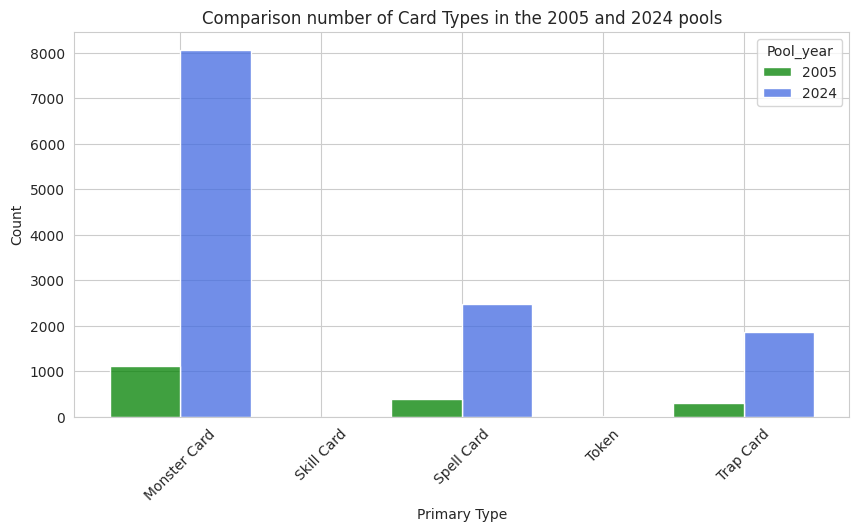

In [27]:
# Plot count
pool_cards_2005 = pool_cards_2005.assign(Pool_year="2005")
pool_cards_2024 = pool_cards_2024.assign(Pool_year="2024")

combined_pool = pd.concat([pool_cards_2005, pool_cards_2024])

plt.figure(figsize=(10, 5))
sns.histplot(data=combined_pool, x="primary_type", hue="Pool_year", multiple="dodge", palette={"2005": "green", "2024": "royalblue"})

plt.xticks(rotation=45) 
plt.xlabel("Primary Type")
plt.ylabel("Count")
plt.title("Comparison number of Card Types in the 2005 and 2024 pools")

plt.show()

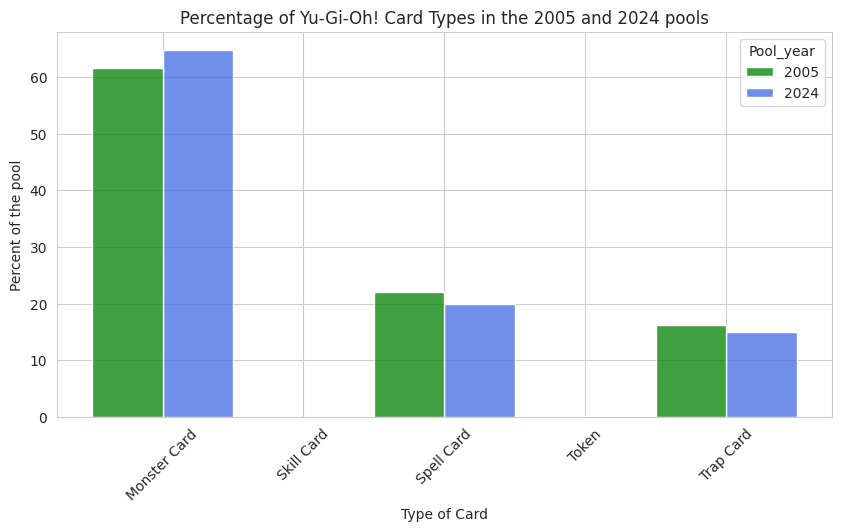

In [28]:
#Plot percentage

# Plot
plt.figure(figsize=(10, 5))
sns.histplot(data=combined_pool, x="primary_type", hue="Pool_year", multiple="dodge",stat="percent",common_norm=False, palette={"2005": "green", "2024": "royalblue"})

plt.xticks(rotation=45)  
plt.xlabel("Type of Card")
plt.ylabel("Percent of the pool")
plt.title("Percentage of Yu-Gi-Oh! Card Types in the 2005 and 2024 pools")

plt.show()


The ditribution of the types Yu-Gi-Oh! cards in both 2005 and 2024 pools seem to be relatively similar.
But there are a lot of different types of monsters as you might have seen in the first plot. And they can greatly impact the game regardless of their Attack and Defense points.

The specific subtype of Monster will be studied in an updated version of this EDA or a following up one.

### Monsters parameters

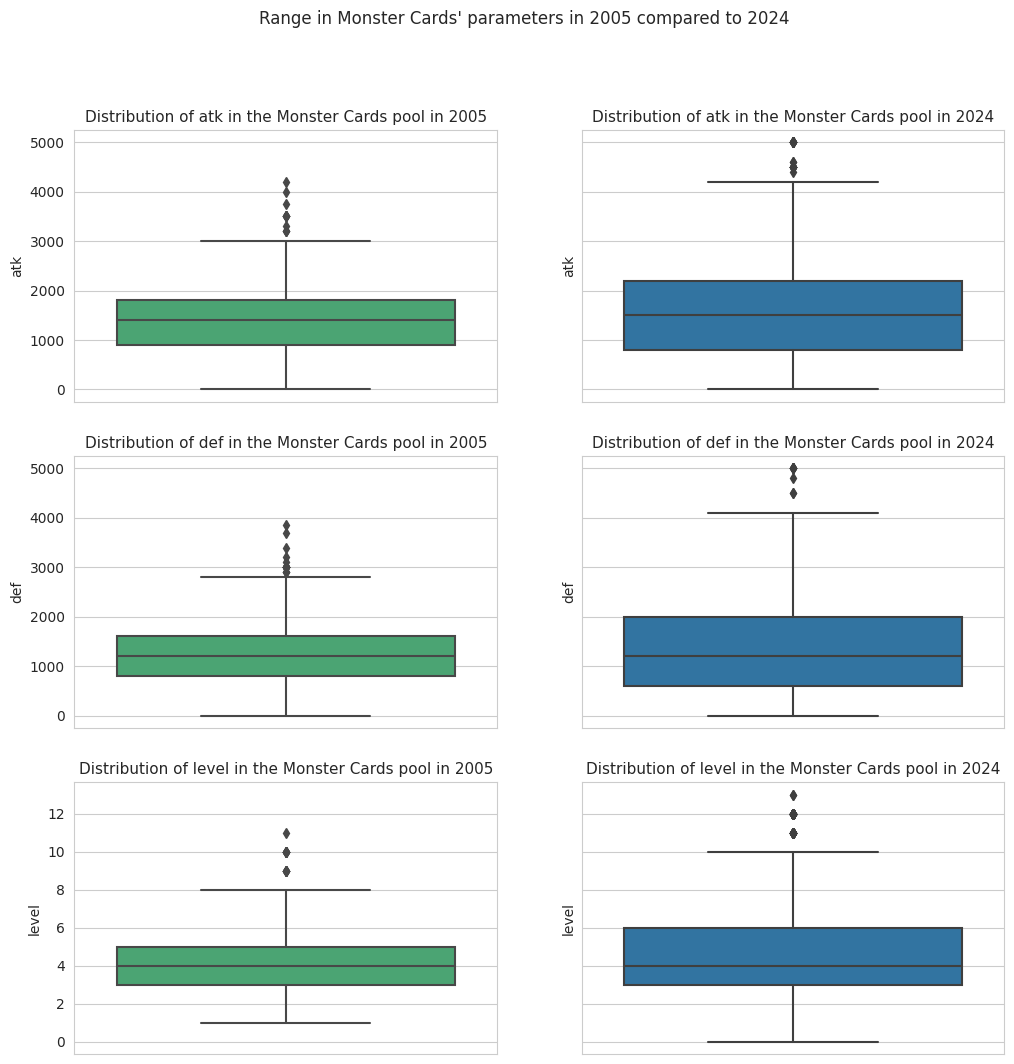

The box plots allow to see the range of where the cards are situated depending on the parameter chosen regarless of the different size of pools.


In [29]:
#box plot to analyse the spread of data through the quartiles
fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharey='row')

fig.suptitle("Range in Monster Cards' parameters in 2005 compared to 2024", ha = "center")

#atk
sns.boxplot(y=pool_monsters_2005["atk"], color='mediumseagreen' , ax=axes[0,0])
axes[0,0].set_title("Distribution of atk in the Monster Cards pool in 2005", fontsize=11)
#faut enlever les cartes bannies
sns.boxplot(y=pool_monsters_2024["atk"],  ax=axes[0,1])
axes[0,1].set_title("Distribution of atk in the Monster Cards pool in 2024", fontsize=11)

#def
sns.boxplot(y=pool_monsters_2005["def"], color='mediumseagreen' , ax=axes[1,0])
axes[1,0].set_title("Distribution of def in the Monster Cards pool in 2005", fontsize=11)

sns.boxplot(y=pool_monsters_2024["def"],  ax=axes[1,1])
axes[1,1].set_title("Distribution of def in the Monster Cards pool in 2024", fontsize=11)

#level
sns.boxplot(y=pool_monsters_2005["level"], color='mediumseagreen' , ax=axes[2,0])
axes[2,0].set_title("Distribution of level in the Monster Cards pool in 2005", fontsize=11)

sns.boxplot(y=pool_monsters_2024["level"],  ax=axes[2,1])
axes[2,1].set_title("Distribution of level in the Monster Cards pool in 2024", fontsize=11)

plt.show()

print("The box plots allow to see the range of where the cards are situated depending on the parameter chosen regarless of the different size of pools.")


## The complexification of the game through the descriptions of the cards - investigating chains

According to Wikipedia, this is the definition of Chains in the Yu-Gi-Oh game :

> A chain is a stack of card effects activated one after the other. It exists for the management of multiple card effects.A chain is created when the effects of more than one card are activated at the same time, or when a player activates an effect after a card is played, but before the card impacts the game.If the effect of a card is activated, the opponent always has the possibility to reply with an effect of their own cards, thus creating a chain.If your opponent replied with an effect, you can choose to reply back and add another effect to the chain. If your opponent chooses not to reply, you can add a second effect and create a chain off of the activation of your own card. Each player can then continue to add effects to the chain. The chain ends when the players wish to not play any more cards. Should this happen, the chain is resolved: the resolution is performed in reverse order of play, starting with the effect of the most recently played card.It is advised to not resolve card effects before ensuring that a chain had not been created.


In [30]:
#format the descriptions
cards_data["number_char_in_desc"]=cards_data["desc"].astype(str).apply(len)

cards_data["reformated_desc"]=cards_data["desc"].str.lower()

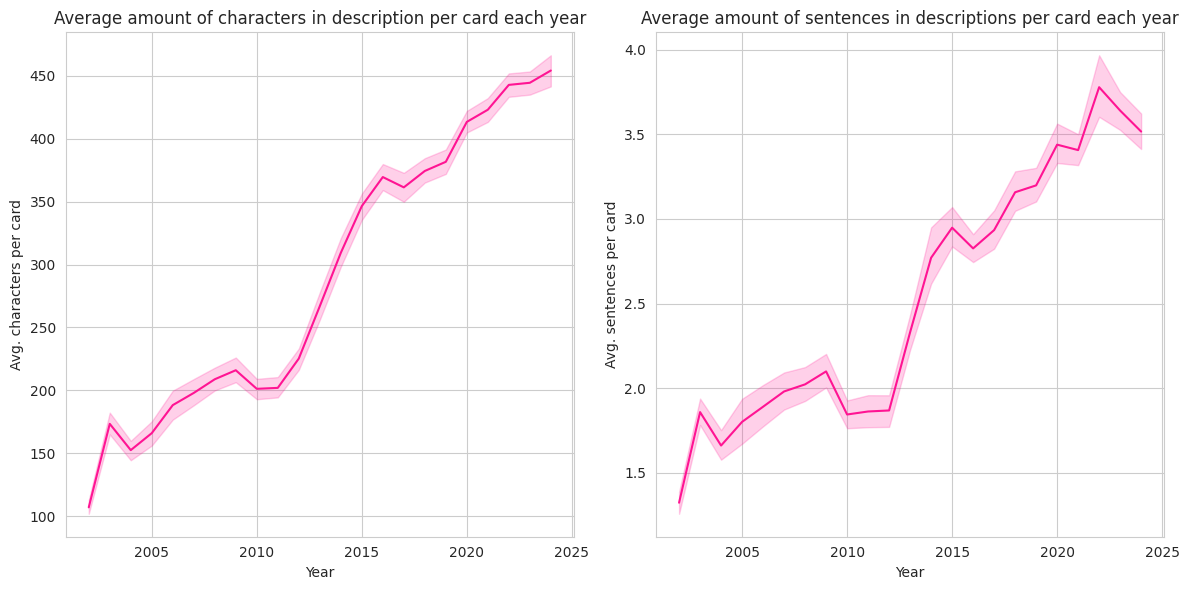

In [31]:
#size of the description
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(cards_data, x="tcg_year", y="number_char_in_desc", color='deeppink', ax=axes[0])
axes[0].set_title("Average amount of characters in description per card each year")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Avg. characters per card")

sns.lineplot(cards_data, x="tcg_year", y=cards_data["desc"].str.count(r'\.'),color='deeppink', ax=axes[1])
axes[1].set_title("Average amount of sentences in descriptions per card each year")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Avg. sentences per card")

plt.tight_layout()
plt.show()

The trends seem to be very similar until around 2015 when the number of characters keep increasing at a high rate.  
Maybe because other other punctuation allow longer sentenses ? Let's see below.

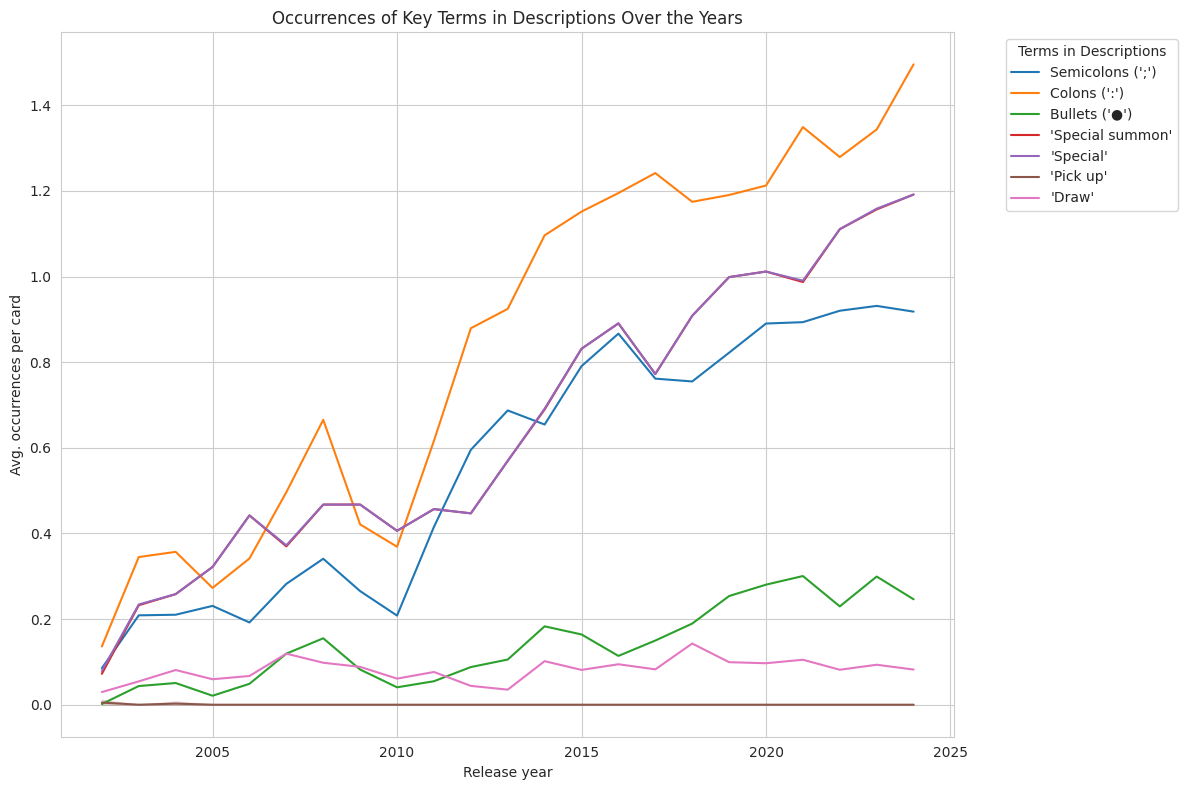

In [32]:
#investigating key words and punctuation

plt.figure(figsize=(12, 8))

# Plot all the lines on the same figure
sns.lineplot(cards_data, x="tcg_year", y=cards_data["desc"].str.count(';'), label="Semicolons (';')",errorbar=None)
sns.lineplot(cards_data, x="tcg_year", y=cards_data["desc"].str.count(':'), label="Colons (':')",errorbar=None)
sns.lineplot(cards_data, x="tcg_year", y=cards_data["desc"].str.count('●'), label="Bullets ('●')",errorbar=None)
sns.lineplot(cards_data, x="tcg_year", y=cards_data["reformated_desc"].str.count('special summon'), label="'Special summon'",errorbar=None)
sns.lineplot(cards_data, x="tcg_year", y=cards_data["reformated_desc"].str.count('special'), label="'Special'",errorbar=None)
sns.lineplot(cards_data, x="tcg_year", y=cards_data["reformated_desc"].str.count('pick up'), label="'Pick up'")
sns.lineplot(cards_data, x="tcg_year", y=cards_data["reformated_desc"].str.count('draw'), label="'Draw'",errorbar=None)

# labels and title
plt.title("Occurrences of Key Terms in Descriptions Over the Years")
plt.xlabel("Release year")
plt.ylabel("Avg. occurrences per card")
plt.legend(title="Terms in Descriptions", bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()  
plt.show()

Annecdotaly, I have heard players complain about the meaning of a desription being completely different if there is a semicolon or a coma. 

To respond to the plots above: yes, punctuation marks have increased which could explain that the sentences are longer.  

But as is shown on the plot above, there seems to have been an event around 2010 that affected greatly the use of colons, semi-colons and the use of the word 'special'.  
The use of the word 'special' highly correlated to the expression 'special summon' on the plot, makes it difficult to even see the red colour with which it is represented.

The explaination of a wider use of punctuation mark starting around 2010 could very well possibly be the implementation of **Problem-Solving Card Text**. 
> Problem-Solving Card Text (often abbreviated PSCT) is a method of writing card text used for TCG prints released from July 8, 2011 onward. The purpose of Problem-Solving Card Text is to specify card effects to the point that most situations can be resolved by logically interpreting the card text.  
> source: [http://yugipedia.com/wiki/Problem-Solving_Card_Text](http://)